In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split,GridSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [13]:

df=pd.read_csv(r"C:\Users\mrqad\Downloads\GrandProject\data\credit_risk.csv")

In [3]:
df

,Id,Age,Income,Home,Emp_length,Intent,Amount,Rate,Status,Percent_income,Default,Cred_length
0,0,22,59000,RENT,123.0,PERSONAL,35000,16.02,1,0.59,Y,3
1,1,21,9600,OWN,5.0,EDUCATION,1000,11.14,0,0.10,N,2
2,2,25,9600,MORTGAGE,1.0,MEDICAL,5500,12.87,1,0.57,N,3
3,3,23,65500,RENT,4.0,MEDICAL,35000,15.23,1,0.53,N,2
4,4,24,54400,RENT,8.0,MEDICAL,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,32576,57,53000,MORTGAGE,1.0,PERSONAL,5800,13.16,0,0.11,N,30
32577,32577,54,120000,MORTGAGE,4.0,PERSONAL,17625,7.49,0,0.15,N,19
32578,32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,35000,10.99,1,0.46,N,28
32579,32579,56,150000,MORTGAGE,5.0,PERSONAL,15000,11.48,0,0.10,N,26


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              32581 non-null  int64  
 1   Age             32581 non-null  int64  
 2   Income          32581 non-null  int64  
 3   Home            32581 non-null  object 
 4   Emp_length      31686 non-null  float64
 5   Intent          32581 non-null  object 
 6   Amount          32581 non-null  int64  
 7   Rate            29465 non-null  float64
 8   Status          32581 non-null  int64  
 9   Percent_income  32581 non-null  float64
 10  Default         32581 non-null  object 
 11  Cred_length     32581 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 3.0+ MB


In [14]:
df.drop(columns=["Id"],axis=1, inplace = True)

In [15]:
#Dropping duplicate values 
df.drop_duplicates(inplace=True)
df = df.reset_index(drop=True)#Resetting the index to make it continuous

In [16]:
max_ages = (df.Age > 99) | (df.Emp_length > 90)
max_ages = df[max_ages]
print(f"Total rows:{len(max_ages)}")
max_ages

Total rows:7


,Age,Income,Home,Emp_length,Intent,Amount,Rate,Status,Percent_income,Default,Cred_length
0,22,59000,RENT,123.0,PERSONAL,35000,16.02,1,0.59,Y,3
81,144,250000,RENT,4.0,VENTURE,4800,13.57,0,0.02,N,3
183,144,200000,MORTGAGE,4.0,EDUCATION,6000,11.86,0,0.03,N,2
210,21,192000,MORTGAGE,123.0,VENTURE,20000,6.54,0,0.10,N,4
575,123,80004,RENT,2.0,EDUCATION,20400,10.25,0,0.25,N,3
747,123,78000,RENT,7.0,VENTURE,20000,NaN,0,0.26,N,4
32132,144,6000000,MORTGAGE,12.0,PERSONAL,5000,12.73,0,0.00,N,25


In [19]:
df.drop(columns=["Cred_length"],axis=1, inplace = True)

In [17]:
rows_to_drop = max_ages.index
df.drop(rows_to_drop, inplace = True)
df = df.reset_index(drop=True)
df.shape

(32409, 11)

In [18]:
df.columns

Index(['Age', 'Income', 'Home', 'Emp_length', 'Intent', 'Amount', 'Rate',
       'Status', 'Percent_income', 'Default', 'Cred_length'],
      dtype='object')

In [11]:
df.groupby("Status")[['Age', 'Income', 'Home', 'Emp_length', 'Intent', 'Amount', 'Rate', 'Percent_income', 'Default', 'Cred_length']].count()

,Age,Income,Home,Emp_length,Intent,Amount,Rate,Percent_income,Default,Cred_length
Status,,,,,,,,,,
0,25321,25321,25321,24715,25321,25321,22868,25321,25321,25321
1,7088,7088,7088,6807,7088,7088,6447,7088,7088,7088


In [21]:
X = df.drop(columns=["Status"])
Y = df["Status"]

In [22]:
X_train,X_val,y_train,y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train.shape,y_train.shape,X_val.shape,y_val.shape

((25927, 9), (25927,), (6482, 9), (6482,))

In [23]:
num_cols = X_train.select_dtypes(include=["int64","float64"]).columns
catg_cols = X_train.select_dtypes(include=["object"]).columns

In [24]:
def transformers():
    numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values with mean imputation
    ('scaler', MinMaxScaler())                  # Feature scaling
        ])
    categorical_transformer = Pipeline([
    ('onehot',  OneHotEncoder(handle_unknown='ignore', drop='first'))
        ])
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols),
        ('cat', categorical_transformer, catg_cols)
        ])
    return preprocessor
preprocessor=transformers()


In [25]:
def pipeline_master(preprocessor):
    # XGBoostClassifier
    xgb_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('xgb', XGBClassifier())
    ])

    # RandomForestClassifier
    rfc_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('rf', RandomForestClassifier(random_state=42))
    ])
    log_reg_pipeline=Pipeline([
        ('preprocessor',preprocessor),
        ('log_reg',LogisticRegression())
    ])
    return xgb_pipeline,rfc_pipeline,log_reg_pipeline
xgb_pipeline,rfc_pipeline,log_reg_pipeline=pipeline_master(preprocessor=preprocessor)

In [26]:
log_model=log_reg_pipeline.fit(X_train,y_train)

In [70]:
y_pred_log=log_model.predict(X_val)

In [71]:
accuracy_score(y_pred_log,y_val)

0.8474236346806541

In [27]:
def gridcvSearching(pipeline,params):
    grid_cv = GridSearchCV(pipeline, params, scoring="recall", cv=5)
    return grid_cv

In [28]:
# Testing different parameters for Gradient Boosting
param_xgb  = {
    'xgb__learning_rate': [0.07,0.1,0.15],  # Learning rate
    'xgb__n_estimators': [300,700,1000],    # Number of estimators (trees)
    'xgb__reg_alpha': [0.05,0.1,1.0]        # L1 Regularization(Lasso)
}


xgb_pipeline_grid=gridcvSearching(xgb_pipeline,param_xgb)


In [29]:
def fitting_grids(grid_cv,x_train,y_train):
    grid_cv.fit(x_train,y_train)
    best_params = grid_cv.best_params_
    return best_params

    

In [30]:
best_params_xgb=fitting_grids(xgb_pipeline_grid,X_train,y_train)


In [31]:
best_params_xgb

{'xgb__learning_rate': 0.15, 'xgb__n_estimators': 1000, 'xgb__reg_alpha': 0.1}

In [32]:
xgb_pipeline_grid.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['Age', 'Income', 'Emp_length', 'Amount', 'Rate', 'Percent_income'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  Index(['Home', 'Intent', 'Default']...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.15,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=1000, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [33]:
# XGBoostClassifier
best_xgbc_pipeline = xgb_pipeline_grid.best_estimator_
best_xgbc_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['Age', 'Income', 'Emp_length', 'Amount', 'Rate', 'Percent_income'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  Index(['Home', 'Intent', 'Default']...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.15,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=1000, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [60]:
rfc_model=rfc_pipeline.fit(X_train,y_train)

In [61]:
rfc_pred=rfc_model.predict(X_val)

In [62]:
accuracy_score(rfc_pred,y_val)

0.9211663066954644

In [34]:
xgb_model=best_xgbc_pipeline.fit(X_train,y_train)

In [35]:
pred=xgb_model.predict(X_val)

In [36]:
accuracy_score(pred,y_val)

0.9273372415921012

In [37]:
def pred_eval(model,pred_set,target): 
    
    model_pred = model.predict(pred_set)
    
    conf_matrix = confusion_matrix(target,model_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()
    
    accuracy = accuracy_score(target,model_pred)
    classification_rep = classification_report(target,model_pred)
    print("Accuracy:", accuracy)
    print("Classification Report:\n", classification_rep)        

### Evaluating Random Forest


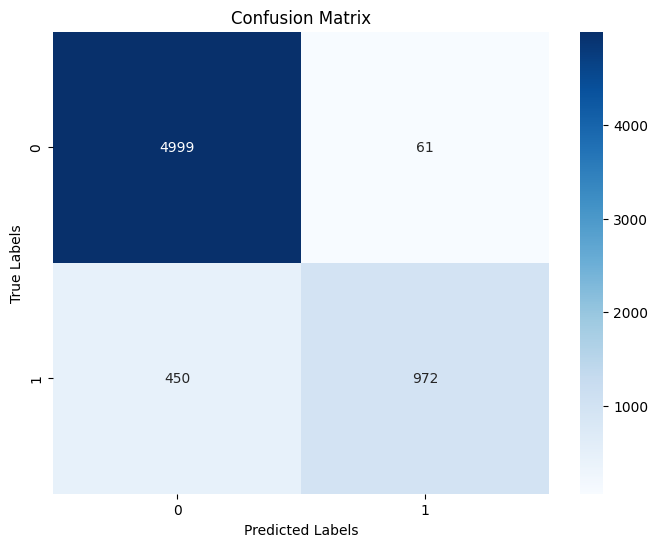

Accuracy: 0.9211663066954644
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.95      5060
           1       0.94      0.68      0.79      1422

    accuracy                           0.92      6482
   macro avg       0.93      0.84      0.87      6482
weighted avg       0.92      0.92      0.92      6482



In [64]:
pred_eval(rfc_model,X_val,y_val)

### Evaluating XGBoost


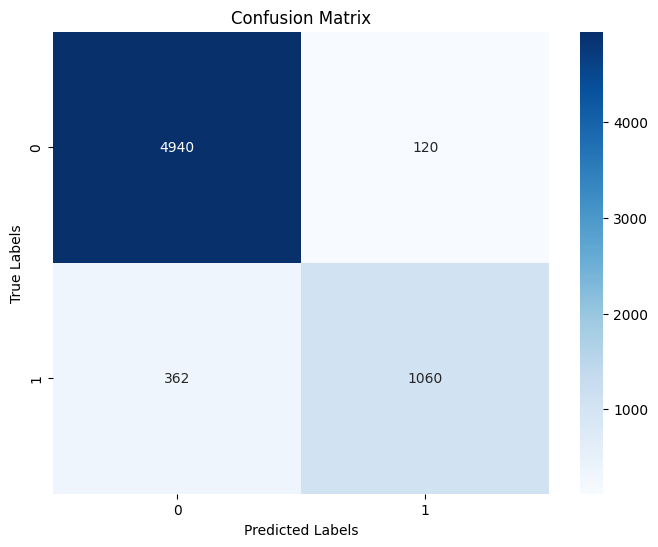

Accuracy: 0.9256402344955261
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.95      5060
           1       0.90      0.75      0.81      1422

    accuracy                           0.93      6482
   macro avg       0.92      0.86      0.88      6482
weighted avg       0.92      0.93      0.92      6482



In [66]:
pred_eval(xgb_model,X_val,y_val)

In [74]:
import os 
os.path.join("models")

'models'

In [38]:
import pickle
# models\model.pkl
# model_path = os.path.join("models", 'xgb_model.pkl')
with open('xgb_model.pkl','wb') as file:
    pickle.dump(xgb_model,file)
